<a href="https://colab.research.google.com/github/conster303/PFA_ML_Sandbox_CMS/blob/main/PFA_preprocess_TsNE_April.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preprocess

## import libraries, preprocessing, and set up drive connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.neural_network import MLPClassifier 
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
import tensorflow.keras.backend as K
from scipy.spatial.distance import cdist


from sklearn.decomposition import NMF 
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import normalize



from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from mpl_toolkits.axes_grid1 import make_axes_locatable

import random

from scipy.stats import uniform
import pickle
import datetime
import time
import torch
from pathlib import Path
import sys


#If we want to reproduce results/deterministic solutions, pass an integer for random_state

RS = 42 # https://en.wikipedia.org/wiki/42_(number)#The_Hitchhiker's_Guide_to_the_Galaxy
#RS = None

#Set initialization for NMF models 

init = 'random'
#init = 'nndsvd'

#randomness comes from train/test/split as well. 

In [ ]:
#Set up directory where data is stored in your google drive

#%cd '/content/drive/My Drive/October_PFA'
%cd '/content/drive/MyDrive/PFA_March/PFA_MARCH_FILES'

/content/drive/MyDrive/PFA_March/PFA_MARCH_FILES


In [ ]:
def timeNow():
    '''
    returns current date as a string
    '''
    now = datetime.datetime.now()
    full = "-" + str(now.month) + "-" + str(now.day) + "-" + str(now.year) + \
           '-' + str(now.hour).zfill(2) + ':' + str(now.minute).zfill(2) + ':' + str(now.second).zfill(2)

    return full

In [ ]:
pip install --upgrade tables

     |████████████████████████████████| 4.3MB 18.9MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [ ]:
#Import PFA master hdf file preprocessing
import PFA_preprocessing_february2021 as pfa

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
#To access a gpu (not needed unless for clustering) go to runtime tab, select change runtime type, select GPU then run line to check
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## load PFA data

In [ ]:
df_features = pd.read_hdf('./PFA_dataframe_grid_march2021_df.h5', 'df_features')

In [ ]:
df_features.tail()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,HorizGravityGradient2,HorizMagneticGradient2,GravityDensity,MagneticDensity,Heatflow,GeochemistryTemperature2,Tufa_Distance,Travertine_Distance,Silica_Distance,TufaOrTravertine_Distance,FavorableStructuralSettings_Distance,Local-StructuralSetting_Error,Local-QuaternaryFaultRecency_Error,Local-QuaternaryFaultSlipDilation_Error,Local-QuaternaryFaultSlipRate_Error,QuaternaryFaultTraces_Error,HorizGravityGradient_Error,GeodeticStrainRate_Error,QuaternarySlipRate_Error,FaultRecency_Error,Earthquakes_Error,Heatflow_Error,HorizGravityGradient2_Confidence,HorizMagneticGradient2_Confidence,Hillshade-100m,DEM-30m,Fairway,Domain,T37
1727995,999.0,1723.0,R1000C1724,717077.690182,4.508464e+06,nullValue,12,12,12,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0,-9999.0,-1.0,2.11394,-9999.0,0.397940,0.004456,0.000005,-9999,-9999,91.726402,-9999.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-9999.0,0.577983,0.537311,0.788923,0.403113,0.453099,22.451099,0.190986,4,180,1703,-9999.0,0,12
1727996,999.0,1724.0,R1000C1725,717327.690182,4.508464e+06,nullValue,12,12,12,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0,-9999.0,-1.0,2.11394,-9999.0,0.176091,0.004581,0.000005,-9999,-9999,91.769501,-9999.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-9999.0,0.577983,0.536572,0.788923,0.403113,0.468096,22.432301,0.203718,4,180,1705,-9999.0,0,12
1727997,999.0,1725.0,R1000C1726,717577.690182,4.508464e+06,nullValue,12,12,12,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0,-9999.0,-1.0,2.11394,-9999.0,0.176091,0.004699,0.000005,-9999,-9999,91.813103,-9999.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-9999.0,0.600598,0.535831,0.788923,0.403113,0.468096,22.413500,0.190986,4,180,1703,-9999.0,0,12
1727998,999.0,1726.0,R1000C1727,717827.690182,4.508464e+06,nullValue,12,12,12,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0,-9999.0,-1.0,2.11394,-9999.0,0.176091,0.004806,0.000005,-9999,-9999,91.857399,-9999.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-9999.0,0.615751,0.535089,0.788923,0.403113,0.468096,22.394600,0.165521,4,180,1702,-9999.0,0,12
1727999,999.0,1727.0,R1000C1728,718077.690182,4.508464e+06,nullValue,12,12,12,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0,-9999.0,-1.0,2.11394,-9999.0,0.176091,0.004899,0.000005,-9999,-9999,91.902298,-9999.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-9999.0,0.615751,0.534346,0.788923,0.403113,0.468096,22.375601,0.165521,4,180,1702,-9999.0,0,12


(1728000,)


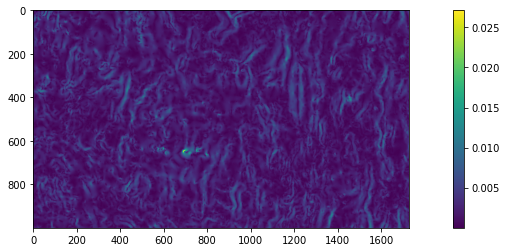

In [ ]:
SD = df_features['HorizGravityGradient2'].to_numpy().astype(float)
print(SD.shape)
plt.rc('figure', figsize=(16,4))
SD =np.reshape(SD,(1000,1728))

#invert so it is oriented correctly
SD = np.flipud(SD)
plt.imshow(SD)
plt.colorbar()

In [ ]:
df_SSlookup = pd.read_hdf('PFA_structuralSettingsLookup_october2020_df.h5', 'df_SSLookup')
df_SSlookup.head()

,Local_polygon_Id,Local_polygon_overlap_Id,Label,Label2,Label3
0,1,1,AZ,NaN,NaN
1,2,2,FT,NaN,NaN
2,3,3,SO,NaN,NaN
3,4,4,SO,NaN,NaN
4,7,7,SO,NaN,NaN


In [ ]:
#Dataframe with attributes for KGS/wells, names, temperatue values, blind label, Nameplate capacity, well type, and depth
url = 'https://raw.githubusercontent.com/connormacs/Geothermal-Rising-ML-GeoStats-Workshop/main/PFA_TSITES.csv'

df_Tsite_GIS = pd.read_csv(url)
df_Tsite_GIS.head()

,Id,QuaternaryFaultDensity,HorizGravityGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency,Earthquakes,HorizMagneticGradient2,Heatflow,DEM-30m,X_83UTM11,Y_83UTM11,TrainCodeNeg,TrainCodePos,TrainCodePosT130,TrainCodePosT37,NAME,MAX_MAXT,Blind,POWER,E_utm83,N_utm83,Depth(m)
0,6,1.285103,-1.179981,1.327701,-0.875585,-1.595637,0.116588,0.187495,1.161904,0.765071,-0.387379,325827.6902,4261213.766,12,1,12,1,Grant View Hot Springs,53.0,no,0.0,325910.7938,4261123.388,NaN
1,78,0.200934,3.224230,0.042698,0.925116,-0.450002,-0.557711,0.779572,-0.095253,-1.670693,-0.949648,626327.6902,4262713.766,12,1,1,12,Bacon Flat,130.0,yes,0.0,626240.6513,4262689.377,NaN
2,27,0.530642,0.346868,1.670390,2.105045,0.760399,-0.140574,2.492251,1.213427,0.415872,-1.109560,356327.6902,4263213.766,12,1,12,1,Hawthorne 1,97.0,yes,0.0,356239.0985,4263285.061,NaN
3,82,2.520683,-0.845162,-0.276014,-0.920538,-1.178281,-0.632902,1.053704,-0.589872,-1.448916,-0.250680,555077.6902,4263713.766,12,1,1,12,Hot Creek Ranch Hot Spr,160.0,no,0.0,555117.5865,4263714.281,NaN
4,31,0.328629,3.224230,0.004236,0.698215,-0.420560,-0.177550,0.706009,-0.899009,-1.639976,-0.923856,628327.6902,4269213.766,12,1,12,1,Blue Eagle Springs,41.0,no,0.0,628207.4400,4269285.723,NaN


In [ ]:
df_features = df_features.replace(np.nan,0.0)

In [ ]:
df_features['Silica_Distance'].isnull().values.any()

False

## preprocess data

In [ ]:
extraFeatures = ['GravityDensity', 'MagneticDensity', 
                 'GeochemistryTemperature2',
                 'Silica_Distance', 'TufaOrTravertine_Distance',
                 'DEM-30m', 'FavorableStructuralSettings_Distance']

# extraFeatures = None

Call pfa.preprocess. Coded N for numerical, C for categorical.

N is 0-1.2 scoring for 'Local-StructuralSetting', and C is 19 different structures 1hot encoded (~7 major and 12 hybrid).

The data is reduced (z-score) and scaled (standard). 

Distance from faults = distance_edt, also have option to change to gaussian filter 'gaussianFilter'

In [ ]:
# transformDict = {}

transformDict = {'features': ['Local-StructuralSetting',
                              'Local-QuaternaryFaultRecency',
                              'Local-QuaternaryFaultSlipDilation', 
                              'Local-QuaternaryFaultSlipRate',
                              'QuaternaryFaultTraces'], 
                 'transforms': ['gaussianFilter', 
                                'gaussianFilter', 
                                'gaussianFilter', 
                                'gaussianFilter', 
                                'distance_edt'], 
                 'params': [10, 10, 10, 10, 20]}

# transformDict = {'features': ['QuaternaryFaultTraces'], 
#                  'transforms': ['distance_edt'], 
#                  'params': [20]}

dfn, dfInfo, nullIndexes, scaler = pfa.preprocess_features_AllNumerical(df_features,
                                                                          transformFeatures=transformDict,
                                                                          extraFeatures=extraFeatures, 
                                                                          prescaleFeatures=True, withMean=True)

# dfn, dfInfo, nullIndexes, scaler = pfa.preprocess_features_LocalNumerical(df_features, 
#                                                                           resetLocal=None,
#                                                                           transformFaultTraces='distance_edt',
#                                                                           extraFeatures=extraFeatures, 
#                                                                           prescaleFeatures=True)

# dfc, dfInfoc, nullIndexesc, scalerc = pfa.preprocess_features_LocalCategorical(df_features.copy(), df_SSlookup,
#                                                                                resetLocal=None,
#                                                                                transformFaultTraces='distance_edt',
#                                                                                extraFeatures=None,
#                                                                                prescaleFeatures=True)

In [ ]:
dfn

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance
0,-0.523680,-0.568900,-0.399442,-0.568584,0.521096,-0.506811,-1.146319,1.738459,-0.641083,0.664854,-0.469155,2.209502,0.047583,1.320938,1.645851,-0.185826,0.591858,1.103057,0.615938,0.034429
1,-0.523768,-0.569068,-0.399476,-0.568743,0.521096,-0.192541,-1.146319,1.738459,-0.641083,0.664854,-0.459131,2.211017,0.055473,1.205579,1.645851,-0.185826,0.590249,1.101808,0.510190,0.048345
2,-0.523942,-0.569398,-0.399542,-0.569055,0.521096,0.115757,-1.146319,1.738459,-0.641083,0.664854,-0.407871,2.217023,0.062990,1.205579,1.645851,-0.185826,0.588654,1.100629,0.303852,0.063819
3,-0.524196,-0.569881,-0.399638,-0.569513,0.524190,0.339483,-1.146319,1.738459,-0.641083,0.664854,-0.368710,2.211017,0.070240,1.090220,1.645851,-0.185826,0.587074,1.099519,0.347699,0.080813
4,-0.524525,-0.570503,-0.399762,-0.570102,0.533434,0.436512,-1.146319,1.738459,-0.630559,0.640521,-0.363559,2.208005,0.077179,1.090220,1.645851,-0.185826,0.585508,1.098479,0.437972,0.099286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1727996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1727997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1727998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
#Can change name (or not)
#dfn = dfn.rename({'QuaternaryFaultTraces':'QuaternaryFaultDistance'},axis=1)
#dfN = dfN.rename({'QuaternaryFaultTraces':'QuaternaryFaultDensity'},axis=1)
#dfC = dfC.rename({'QuaternaryFaultTraces':'QuaternaryFaultDensity'},axis=1)


In [ ]:
Xall = dfn.copy()
columns = Xall.columns.to_list()
columns

['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'GravityDensity',
 'MagneticDensity',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
 'DEM-30m',
 'FavorableStructuralSettings_Distance']

## select feature set

In [ ]:
featureSets = [

# MASTER SET 1
################################
# featureSet = 0
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 1alt: master set 1 with new gravity/magnetic features substituted
################################
# featureSet = 1
################################
['QuaternaryFaultTraces',
 'GravityDensity',
 'MagneticDensity',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 2: master set 1 + all local
################################
# featureSet = 2
################################
['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 3: master set 1 + geochemistry direct evidence 
################################
# featureSet = 3
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
],
    
# MASTER SET 4: union of master sets 2 and 3
################################
# featureSet = 4
################################
['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
],
    
# MASTER SET 2a: master set 1 + local structural setting
################################
# featureSet = 5
################################
['Local-StructuralSetting',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 2b: master set 1 + favorable structural settings
################################
# featureSet = 6
################################
['FavorableStructuralSettings_Distance',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 4b: union of master sets 2b and 3
################################
# featureSet = 7
################################
['FavorableStructuralSettings_Distance',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
],
    
# MASTER SET 1m: master set 1 minus geodetic strain rate
################################
# featureSet = 8
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
# 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
]

len(featureSets)

9

In [ ]:
feature_set = 0

columns = featureSets[feature_set]

columns

['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m']

In [ ]:
dfInfo['T37'] = df_features['T37']
dfInfo['Domain'] = df_features['Domain']

dfInfo.head()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
0,0.0,0.0,R1C1,286327.690182,4.258714e+06,notNull,12,12,12,9.0,82070.110132,61.0,34166.449170,22.0,122848.502942,0,0,12,1
1,0.0,1.0,R1C2,286577.690182,4.258714e+06,notNull,12,12,12,9.0,81993.349012,61.0,34115.759156,22.0,122726.185082,0,0,12,1
2,0.0,2.0,R1C3,286827.690182,4.258714e+06,notNull,12,12,12,9.0,81917.278930,61.0,34066.828392,22.0,122604.254961,0,0,12,1
3,0.0,3.0,R1C4,287077.690182,4.258714e+06,notNull,12,12,12,9.0,81841.901813,61.0,34019.664470,22.0,122482.713736,0,0,12,1
4,0.0,4.0,R1C5,287327.690182,4.258714e+06,notNull,12,12,12,9.0,81767.219578,61.0,33974.274746,22.0,122361.562567,0,0,12,1


## select benchmark sites based on trainCode distance

Select trainCode=1: for 83+ and 62- or trainCode=2: 415+ and 310-


In [ ]:
X, y, XyInfo = pfa.makeBenchmarks(dfn, dfInfo, nullIndexes, 
                                          trainCode=1, randomize=True, balance=False)

Number of (+):  83   ; Number of (-):  62


In [ ]:
# X, y, XyInfo = pfa.makeBenchmarks(dfC, dfInfoC, nullIndexesC, 
#                                   trainCode=1, randomize=True, balance=True)

In [ ]:
print( X.shape, y.shape)

(145, 20) (145,)


In [ ]:
X.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance
1231875,-0.532808,-0.586228,-0.402900,-0.584992,0.859628,-0.221502,0.842463,-1.867938,-0.457561,0.966262,1.179762,-0.966196,0.376188,-0.409451,-1.332028,-0.185826,0.184870,0.615644,0.244530,1.151006
375505,0.496117,1.260877,1.455187,1.106650,1.056262,2.328169,0.832158,1.218282,0.584405,-0.107538,0.738235,1.568963,0.842695,-1.563044,-1.446561,3.738153,0.260989,2.098966,-0.903222,-1.770963
1410881,1.457906,2.562670,0.225990,2.396520,-1.064303,0.061109,-0.940228,0.956187,0.214461,-1.178360,0.266093,-0.467806,1.255569,-1.563044,0.958648,3.104600,-0.338714,-1.665807,-0.887747,-1.097836
572227,-0.015105,-0.176779,-0.321192,-0.197309,1.461942,1.636441,1.728656,1.260158,-0.095780,-0.264404,-1.830769,0.546905,1.466387,-1.678404,-1.561095,7.579027,-1.128263,-1.655954,-1.522235,-1.775994
906804,-0.532771,-0.586163,-0.402886,-0.584922,-0.271604,-1.174651,-0.569263,-1.073156,-0.468041,0.532708,0.903778,-0.135656,-1.644967,1.436297,0.271446,-0.185826,0.897456,1.955611,1.157574,1.090373


In [ ]:
y

1231875    0
375505     1
1410881    1
572227     1
906804     0
          ..
1127827    1
1578088    1
283787     1
35635      1
1493247    1
Name: labels, Length: 145, dtype: int64

In [ ]:
XyInfo.head()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
1231875,712.0,1539.0,R713C1540,671077.690182,4.436714e+06,notNull,1,12,12,14.0,63183.797381,25.0,21122.515984,15.0,144.294624,0,0,12,4
375505,217.0,529.0,R218C530,418577.690182,4.312964e+06,notNull,12,1,12,24.0,22732.400922,59.0,74.559520,56.0,9385.241520,368,0,1,2
1410881,816.0,833.0,R817C834,494577.690182,4.462714e+06,notNull,12,1,12,57.0,39380.529655,51.0,60.981372,42.0,68248.041873,124,0,1,3
572227,331.0,259.0,R332C260,351077.690182,4.341464e+06,notNull,12,1,1,21.0,100.788271,21.0,100.788271,61.0,19964.267217,89,0,12,1
906804,524.0,1332.0,R525C1333,619327.690182,4.389714e+06,notNull,1,12,12,14.0,107669.459105,47.0,12752.904115,53.0,162.181371,0,0,12,4


In [ ]:
#Create Dataframe with training site info
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
XyInfo.reset_index(drop=True, inplace=True)

Tsite= pd.concat([X,XyInfo],axis=1).reset_index(drop=True)
Tsite

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
0,-0.532808,-0.586228,-0.402900,-0.584992,0.859628,-0.221502,0.842463,-1.867938,-0.457561,0.966262,1.179762,-0.966196,0.376188,-0.409451,-1.332028,-0.185826,0.184870,0.615644,0.244530,1.151006,712.0,1539.0,R713C1540,671077.690182,4.436714e+06,notNull,1,12,12,14.0,63183.797381,25.0,21122.515984,15.0,144.294624,0,0,12,4
1,0.496117,1.260877,1.455187,1.106650,1.056262,2.328169,0.832158,1.218282,0.584405,-0.107538,0.738235,1.568963,0.842695,-1.563044,-1.446561,3.738153,0.260989,2.098966,-0.903222,-1.770963,217.0,529.0,R218C530,418577.690182,4.312964e+06,notNull,12,1,12,24.0,22732.400922,59.0,74.559520,56.0,9385.241520,368,0,1,2
2,1.457906,2.562670,0.225990,2.396520,-1.064303,0.061109,-0.940228,0.956187,0.214461,-1.178360,0.266093,-0.467806,1.255569,-1.563044,0.958648,3.104600,-0.338714,-1.665807,-0.887747,-1.097836,816.0,833.0,R817C834,494577.690182,4.462714e+06,notNull,12,1,12,57.0,39380.529655,51.0,60.981372,42.0,68248.041873,124,0,1,3
3,-0.015105,-0.176779,-0.321192,-0.197309,1.461942,1.636441,1.728656,1.260158,-0.095780,-0.264404,-1.830769,0.546905,1.466387,-1.678404,-1.561095,7.579027,-1.128263,-1.655954,-1.522235,-1.775994,331.0,259.0,R332C260,351077.690182,4.341464e+06,notNull,12,1,1,21.0,100.788271,21.0,100.788271,61.0,19964.267217,89,0,12,1
4,-0.532771,-0.586163,-0.402886,-0.584922,-0.271604,-1.174651,-0.569263,-1.073156,-0.468041,0.532708,0.903778,-0.135656,-1.644967,1.436297,0.271446,-0.185826,0.897456,1.955611,1.157574,1.090373,524.0,1332.0,R525C1333,619327.690182,4.389714e+06,notNull,1,12,12,14.0,107669.459105,47.0,12752.904115,53.0,162.181371,0,0,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,-0.416254,-0.494023,-0.366069,-0.410418,0.978438,0.054881,-0.424999,-1.491312,-0.363878,1.153149,0.945821,-0.787486,-0.463775,0.513423,1.531317,2.556917,-0.059756,0.045029,-0.116561,-1.749883,652.0,1171.0,R653C1172,579077.690182,4.421714e+06,notNull,12,1,12,76.0,81307.242675,48.0,137.712230,12.0,10051.666923,282,0,1,4
141,1.256178,1.571190,1.749735,1.457744,-0.965216,1.724801,0.852767,-0.031941,1.241855,-2.049002,0.062224,-0.643047,0.666837,-1.332326,1.416784,10.883062,-0.978520,0.297676,-1.158565,-1.522226,913.0,424.0,R914C425,392327.690182,4.486964e+06,notNull,12,1,1,8.0,108.518720,8.0,108.518720,5.0,68449.447735,59,0,12,3
142,3.079862,2.842427,4.732612,2.657676,0.477136,-0.308322,0.574544,1.303287,1.103376,-0.474584,-1.416765,0.490366,-0.086706,0.167345,-1.217494,7.062103,-0.012792,0.419977,-1.362323,-0.916966,164.0,395.0,R165C396,385077.690182,4.299714e+06,notNull,12,1,1,84.0,156.038716,84.0,156.038716,56.0,26688.265710,177,0,12,1
143,1.330940,2.361836,0.185405,2.206362,-1.064303,-0.845162,-0.589872,-0.276014,-0.920538,1.178281,-0.632902,1.053704,-1.448916,1.090220,0.500513,6.734515,0.494785,-1.666166,-0.250680,-1.244022,20.0,1075.0,R21C1076,555077.690182,4.263714e+06,notNull,12,1,1,23.0,39.899642,23.0,39.899642,14.0,5882.121049,256,0,12,4


## Create a dataframe with all the normalized data
combines dfN and dfNInfo and includes domains, used for cluster projection into fairway and for fairway NMF/PCA

In [ ]:
#Create a dataframe with all the normalized data

Info = pd.concat([dfn,dfInfo],axis=1,sort=False) #).reset_index(drop=True)
Info.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
0,-0.523680,-0.568900,-0.399442,-0.568584,0.521096,-0.506811,-1.146319,1.738459,-0.641083,0.664854,-0.469155,2.209502,0.047583,1.320938,1.645851,-0.185826,0.591858,1.103057,0.615938,0.034429,0.0,0.0,R1C1,286327.690182,4.258714e+06,notNull,12,12,12,9.0,82070.110132,61.0,34166.449170,22.0,122848.502942,0,0,12,1
1,-0.523768,-0.569068,-0.399476,-0.568743,0.521096,-0.192541,-1.146319,1.738459,-0.641083,0.664854,-0.459131,2.211017,0.055473,1.205579,1.645851,-0.185826,0.590249,1.101808,0.510190,0.048345,0.0,1.0,R1C2,286577.690182,4.258714e+06,notNull,12,12,12,9.0,81993.349012,61.0,34115.759156,22.0,122726.185082,0,0,12,1
2,-0.523942,-0.569398,-0.399542,-0.569055,0.521096,0.115757,-1.146319,1.738459,-0.641083,0.664854,-0.407871,2.217023,0.062990,1.205579,1.645851,-0.185826,0.588654,1.100629,0.303852,0.063819,0.0,2.0,R1C3,286827.690182,4.258714e+06,notNull,12,12,12,9.0,81917.278930,61.0,34066.828392,22.0,122604.254961,0,0,12,1
3,-0.524196,-0.569881,-0.399638,-0.569513,0.524190,0.339483,-1.146319,1.738459,-0.641083,0.664854,-0.368710,2.211017,0.070240,1.090220,1.645851,-0.185826,0.587074,1.099519,0.347699,0.080813,0.0,3.0,R1C4,287077.690182,4.258714e+06,notNull,12,12,12,9.0,81841.901813,61.0,34019.664470,22.0,122482.713736,0,0,12,1
4,-0.524525,-0.570503,-0.399762,-0.570102,0.533434,0.436512,-1.146319,1.738459,-0.630559,0.640521,-0.363559,2.208005,0.077179,1.090220,1.645851,-0.185826,0.585508,1.098479,0.437972,0.099286,0.0,4.0,R1C5,287327.690182,4.258714e+06,notNull,12,12,12,9.0,81767.219578,61.0,33974.274746,22.0,122361.562567,0,0,12,1


In [ ]:
#Check how many domains there are, should be 5 (4 plus study area)
print (Info['Domain'].unique())

[1 3 4 0 2]


(1728000,)


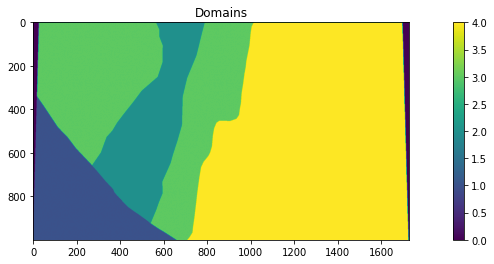

In [ ]:
SD = Info['Domain'].to_numpy().astype(float)
print(SD.shape)
plt.rc('figure', figsize=(16,4))
SD =np.reshape(SD,(1000,1728))
#flip it so it is right side up
SD = np.flipud(SD)
#np.fliplr
#SD =np.reshape(SD,(1263,1344))
plt.imshow(SD)
plt.title('Domains')
plt.colorbar()
# 1 wl, 2 cnsb, 3 wgb, 4 carb

## Explore data at training sites, structures and domains

In [ ]:
##############################
#Tsites
Tsite_Set = Tsite.copy()[columns]
Tsite_Pos = Tsite[Tsite['TrainCodePos']!=12]
Tsite_Neg = Tsite[Tsite['TrainCodePos']==12]
Tsite_PosLOW = Tsite_Pos[Tsite_Pos['TrainCodePosT130']==12] #lower  pos
Tsite_PosBM = Tsite_Pos[Tsite_Pos['TrainCodePosT130']!=12] #Benchmark  pos

##############################
#Structures

#Select data within structures 
df_Struct = Info.copy().loc[Info['Local_polygon_Id'] != 0] 
#take mean values
df_mean_struct = df_Struct.groupby('Local_polygon_Id').mean()

#Reindex structures, there may be 384 total, but they are grouped so that there are actuall 365 and 19 hybrid 
df_mean_struct.index = range(len(df_mean_struct))
All_Struct_Set = df_Struct.copy()[columns]
Struc_Set = df_mean_struct.copy()[columns]

#Labeled dataframe of which structures host Known Geothermal Systems to append after groupby transformation
yStruct = (df_Struct.groupby(['Local_polygon_Id'])['TrainCodePos'].min())
yStruct.index = range(len(yStruct))
yStruct = pd.DataFrame(yStruct) 
 # I use 0 instead of 12 or any number from taking mean
yStruct['TrainCodePos'].replace({12:0, 4:0,9:0,10:0,6:0,8:0,7:0}, inplace=True)
#Replace/update TrainCodePos values 
df_mean_struct = df_mean_struct.drop(['TrainCodePos'], axis = 1)
yStruct.rename(columns = {'TrainCodePos':'TrainCodePos2'}, inplace = True) #Update name to have a 2

##############################
#Domains

WL = Info[Info['Domain'] == 1]
CNSB =  Info[Info['Domain'] == 2]
WGB =  Info[Info['Domain'] == 3]
CAQ = Info[Info['Domain'] == 4]

CAQ_Set = CAQ.copy()[columns]
WL_Set = WL.copy()[columns]
WGB_Set = WGB.copy()[columns]
CNSB_Set = CNSB.copy()[columns]
FRWY_Set = Info.copy()[columns]

# tSNE with Fairway

### PCA + tSNE

In [ ]:
from sklearn.decomposition import PCA
#n = len(FRWY_Set.columns)
pcamodel = PCA(n_components=4)
pcaFRWY = pcamodel.fit_transform (FRWY_Set)

score= pcaFRWY[:,0:2]



#score[:,0].shape
xs = score[:,0]
ys = score[:,1]

<function matplotlib.pyplot.tight_layout>

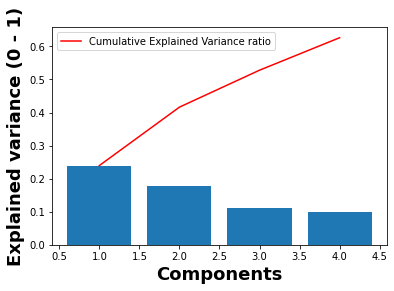

In [ ]:
plt.figure(figsize=(6,4))
#plt.figsize=(20.7,6.27)
plt.bar(range(1,len(pcamodel.explained_variance_ratio_ )+1),pcamodel.explained_variance_ratio_) #width=0.5
plt.ylabel('Explained variance (0 - 1)',fontsize = 18,fontweight='bold')
plt.xlabel('Components',fontsize = 18,fontweight='bold')# fontsize=18,fontweight='bold'
#plt.title(r"Training Sites: Explained Variance" + "\n" + "for Each Principal Component ",fontsize=28,fontweight='bold')


#plt.title('NMF distribution at Structures\n2D NMF/Kmeans clusters - ' + ' Numerical Features',fontsize=14,fontweight='bold');

plt.plot(range(1,len(pcamodel.explained_variance_ratio_ )+1),
         np.cumsum(pcamodel.explained_variance_ratio_),
         c='red',
         label="Cumulative Explained Variance ratio")
plt.legend(loc='upper left',fontsize = 10)
plt.tight_layout

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random')
Y = tsne.fit_transform(pcaFRWY)


Y.shape

We are only going to select 2 or 3 for tsne because tsne is used only for visualization and we can't see things in 3 dimensions. perplexity related to # nearest neighbors. difference can cause drastic changes in results. 

In [ ]:
X = All_Struct_Set

In [ ]:
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

#n_samples = 300
n_components = 2
(fig, subplots) = plt.subplots(3, 5, figsize=(15, 8))
perplexities = [5, 30, 50, 100]

#X, y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)


for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[0], Y[1])
    ax.scatter(Y[0], Y[1])
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')



for i, perplexity in enumerate(perplexities):
    ax = subplots[1][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1])
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


for i, perplexity in enumerate(perplexities):
    ax = subplots[2][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("uniform grid, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1])
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


plt.show()

circles, perplexity=5 in 1.6e+03 sec
circles, perplexity=30 in 1.7e+03 sec
circles, perplexity=50 in 1.8e+03 sec
circles, perplexity=100 in 2.3e+03 sec
S-curve, perplexity=5 in 1.5e+03 sec
S-curve, perplexity=30 in 1.7e+03 sec


#t-Stochastic Neighbor Embedding (t-SNE) 

In [ ]:
""" #Default tSNE parameters
(n_components=2, *, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, 
 n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', init='random', 
 verbose=0, random_state=None, method='barnes_hut', angle=0.5, n_jobs=None, square_distances='legacy') """

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random')
Y = tsne.fit_transform(All_Struct_Set)


Y.shape


(205419, 2)

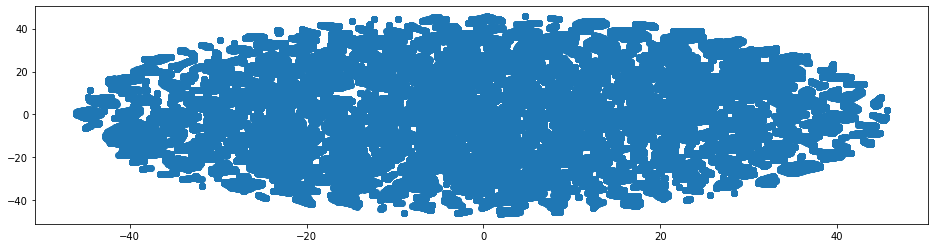

In [ ]:
plt.scatter(Y[:,0],Y[:,1])

In [ ]:
scalex = 1
scaley = 1

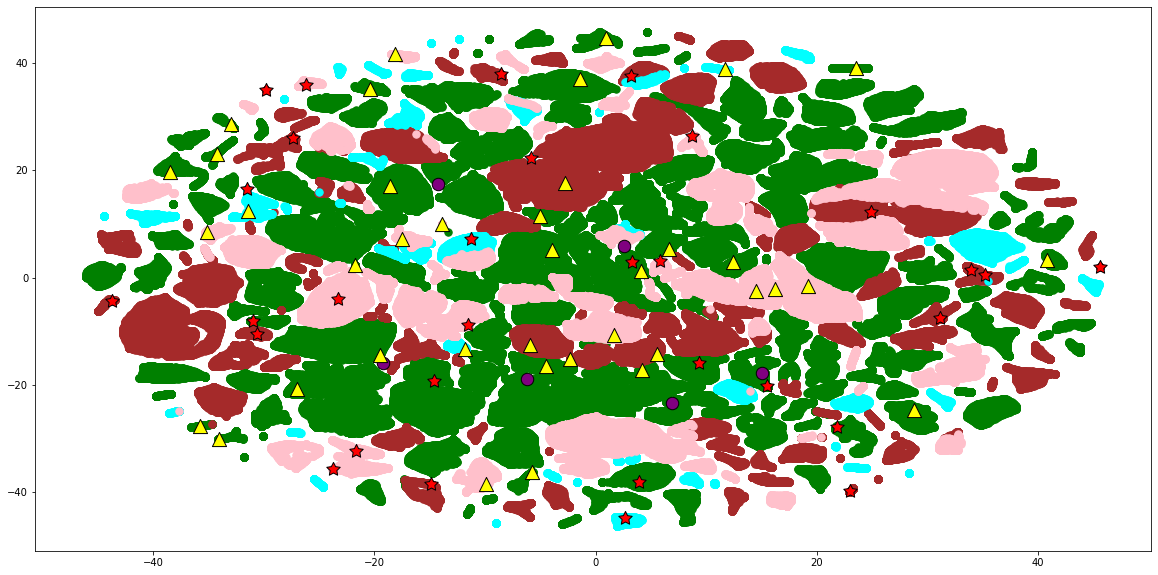

In [ ]:

plt.scatter(Y[df_Struct['Domain']==4,0]*scalex,Y[df_Struct['Domain']==4,1]*scalex,color='green',s=55, label='Carb Aq')
plt.scatter(Y[df_Struct['Domain']==3,0]*scalex,Y[df_Struct['Domain']==3,1]*scalex,color='brown',s=55, label='WGB')
plt.scatter(Y[df_Struct['Domain']==1,0]*scalex,Y[df_Struct['Domain']==1,1]*scalex,color='cyan',s=55, label='Walker Lane')
plt.scatter(Y[df_Struct['Domain']==2,0]*scalex,Y[df_Struct['Domain']==2,1]*scalex,color='pink',s=55, label='CNSB')

plt.scatter(Y[df_Struct['TrainCodeNeg']==1,0]*scalex,Y[df_Struct['TrainCodeNeg']==1,1]*scalex, color='purple',s=155,edgecolors='k', label='Negative T-Site')
plt.scatter(Y[df_Struct['T37']==1,0]*scalex,Y[df_Struct['T37']==1,1]*scalex,color='yellow',edgecolors='k',s=200,marker='^',label='Positive T-Site (39-130°C)')
plt.scatter(Y[df_Struct['TrainCodePosT130']==1,0]*scalex,Y[df_Struct['TrainCodePosT130']==1,1]*scalex,color='red',edgecolors='k',s=200,marker=(5, 1),label='Positive T-Site(>130°C)')



### PCA Kmeans clustering

In [ ]:
df_Struct.reset_index( drop=True,inplace = True, col_level=0, col_fill='')
#df_Struct

In [ ]:
Label_tSNE =  pd.DataFrame(Y,columns = ['tSNE1','tSNE2'])
df_Struct2 = pd.concat([df_Struct,Label_tSNE], axis=1, sort=False)
#df_Struct2

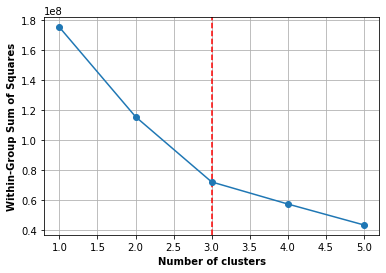

In [ ]:
from sklearn.cluster import KMeans

from sklearn.cluster import MiniBatchKMeans


plt.figure(figsize=(6,4))

distortions = []
for i in range(1, 6):
    km = MiniBatchKMeans(
        n_clusters=i, init='random',
        n_init=10, 
        max_iter=50,
        tol=1e-04, random_state=None
    ) 

    #K-means on the first 4 or so PCs which explain the most variance
    km.fit(df_Struct2[['tSNE1','tSNE2']])
    distortions.append(km.inertia_)

xposition = [3]
for xc in xposition:
    plt.axvline(x=xc, color='red', linestyle='--')
 
# plot
#plt.plot(figsize =(10,10))
plt.plot(range(1, 6), distortions, marker='o')
plt.xlabel('Number of clusters',fontweight='bold')
plt.ylabel('Within-Group Sum of Squares',fontweight='bold')
#plt.title('Pos sites K vs distortion')

plt.grid()
plt.show()

In [ ]:
#Kmeans

df_Struct_reset = df_Struct.reset_index( drop=True,inplace = False, col_level=0, col_fill='')

from sklearn.cluster import KMeans
cols = df_Struct.columns

nCluster = 3

Kmean = MiniBatchKMeans(n_clusters=nCluster, init='k-means++',
               verbose=2)

Kmean.fit(df_Struct2[['tSNE1','tSNE2']])
#KmeanPP.fit(FW[['PC2','PC3','PC4']])

Init 1/3 with method: k-means++
Inertia for init 1/3: 116029.968750
Init 2/3 with method: k-means++
Inertia for init 2/3: 108346.750000
Init 3/3 with method: k-means++
Inertia for init 3/3: 108298.734375
Minibatch iteration 1/205500: mean batch inertia: 348.870117, ewa inertia: 348.870117 
Minibatch iteration 2/205500: mean batch inertia: 387.977461, ewa inertia: 348.908193 
Minibatch iteration 3/205500: mean batch inertia: 362.012109, ewa inertia: 348.920951 
Minibatch iteration 4/205500: mean batch inertia: 382.575977, ewa inertia: 348.953718 
Minibatch iteration 5/205500: mean batch inertia: 326.722363, ewa inertia: 348.932073 
Minibatch iteration 6/205500: mean batch inertia: 382.362188, ewa inertia: 348.964621 
Minibatch iteration 7/205500: mean batch inertia: 364.905625, ewa inertia: 348.980142 
Minibatch iteration 8/205500: mean batch inertia: 381.914180, ewa inertia: 349.012207 
Minibatch iteration 9/205500: mean batch inertia: 364.740625, ewa inertia: 349.027520 
Minibatch ite

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=3, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=2)

In [ ]:
centers = np.copy(Kmean.cluster_centers_)
print('centers.ndim: {}'.format(centers.ndim))
print('centers.shape: {}'.format(centers.shape))
print('centers.size: {}'.format(centers.size))
print(centers)

Labels = Kmean.labels_

centers.ndim: 2
centers.shape: (3, 2)
centers.size: 6
[[-21.813639   11.898285 ]
 [ 18.435019   10.3336735]
 [ -3.1728182 -21.317867 ]]


In [ ]:
df_labels = pd.DataFrame({'KMeansGrp':Labels,
                          'Grp0_CntrX':centers[0,0],
                          'Grp0_CntrY':centers[0,1],
                          'Grp1_CntrX':centers[1,0],
                          'Grp1_CntrY':centers[1,1]})

df_out = pd.concat([df_Struct2, df_labels], axis=1, sort=False)

print("Last 5 rows of df_out:", file=sys.stdout, flush=True)
print(df_out.tail(5).to_string(), file=sys.stdout, flush=True)
print('', file=sys.stdout, flush=True)

Last 5 rows of df_out:
        Local-StructuralSetting  Local-QuaternaryFaultRecency  Local-QuaternaryFaultSlipDilation  Local-QuaternaryFaultSlipRate  QuaternaryFaultTraces  HorizGravityGradient2  HorizMagneticGradient2  GeodeticStrainRate  QuaternarySlipRate  FaultRecency  FaultSlipDilationTendency2  Earthquakes  Heatflow  GravityDensity  MagneticDensity  GeochemistryTemperature2  Silica_Distance  TufaOrTravertine_Distance  DEM-30m  FavorableStructuralSettings_Distance    row  column       id_rc      X_83UTM11     Y_83UTM11   NullInfo  TrainCodeNeg  TrainCodePos  TrainCodePosT130  PosSite130_Id  PosSite130_Distance  PosSite_Id  PosSite_Distance  NegSite_Id  NegSite_Distance  Local_polygon_Id  Local_polygon_overlap_Id  T37  Domain      tSNE1      tSNE2  KMeansGrp  Grp0_CntrX  Grp0_CntrY  Grp1_CntrX  Grp1_CntrY
205414                      0.0                           0.0                                0.0                            0.0                    0.0                    0.0    

In [ ]:
group1 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 0)]
group2 = df_out[df_out['KMeansGrp']==0]
group3 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 0)]

group4 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 1)]
group5 = df_out[df_out['KMeansGrp']==1]
group6 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 1)]

group7 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 2)]
group8 = df_out[df_out['KMeansGrp']==2]
group9 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 2)]


In [ ]:
label1 = 'Positive T-Site - Cluster 1'
label2 = 'Cluster 1'
label3 = 'neg - cluster 1'

label4 = 'Positive T-Site - Cluster 2'
label5 = 'Cluster 2'
label6 = 'neg - cluster 2'

label7 = 'Positive T-Site - Cluster 3'
label8 = 'Cluster 3'
label9 = 'neg - cluster 3'

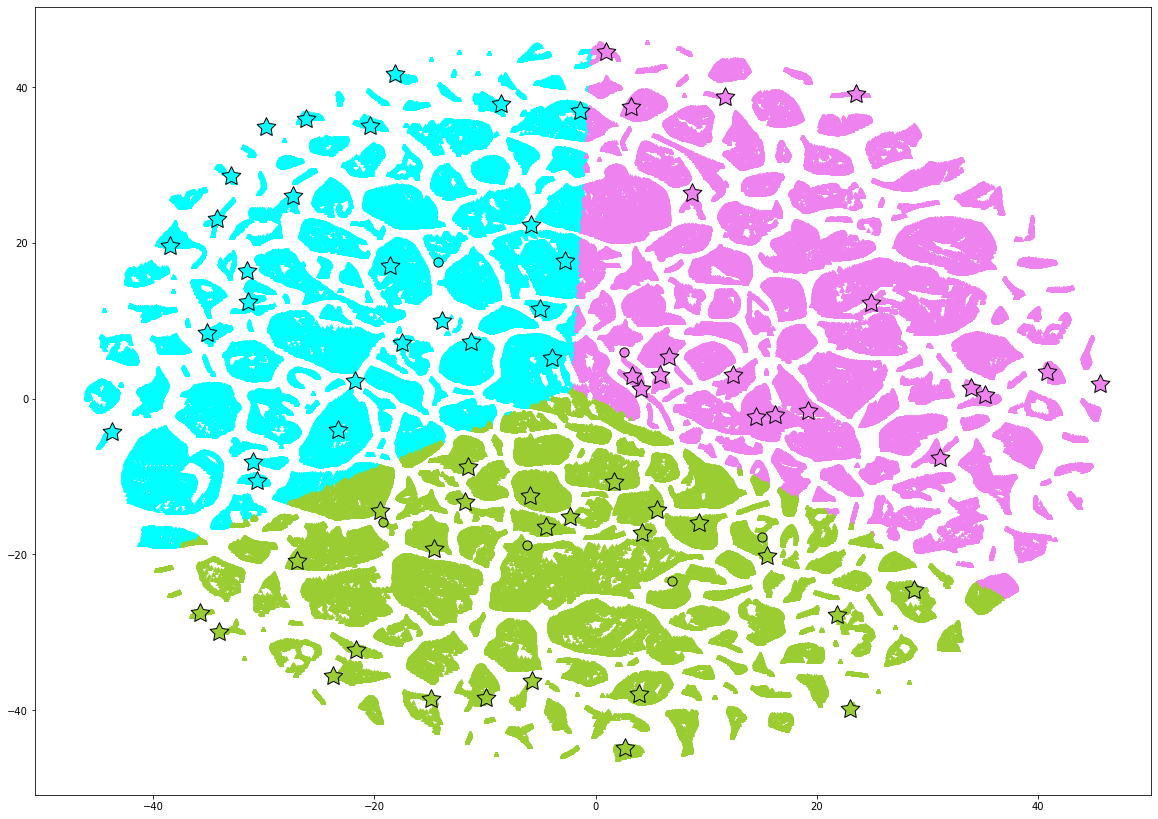

In [ ]:
plt.subplots(figsize=(20,14.5))

plt.scatter(group2['tSNE1'], group2['tSNE2'], c='cyan',s=15,marker='^', label=label2)
plt.scatter(group3['tSNE1'], group3['tSNE2'], c='cyan',edgecolors='k',s=85,marker='o', label=label3)

plt.scatter(group5['tSNE1'], group5['tSNE2'], c='violet',s=15,marker='^',  label=label5)
plt.scatter(group6['tSNE1'], group6['tSNE2'], c='violet',edgecolors='k',s=85,marker='o', label=label6)

plt.scatter(group8['tSNE1'], group8['tSNE2'], c='yellowgreen',s=15,marker='^', label=label8)
plt.scatter(group9['tSNE1'], group9['tSNE2'],  c='yellowgreen',edgecolors='k',s=85,marker='o',label=label9)

plt.scatter(group1['tSNE1'], group1['tSNE2'], c='cyan',edgecolors='k',s=385,marker=(5, 1), label=label1)
plt.scatter(group4['tSNE1'], group4['tSNE2'],  c='violet',edgecolors='k',s=385, marker=(5, 1), label=label4)
plt.scatter(group7['tSNE1'], group7['tSNE2'], c='yellowgreen',edgecolors='k',s=385,marker=(5, 1), label=label7)


### Projection into Fairway

<function matplotlib.pyplot.tight_layout>

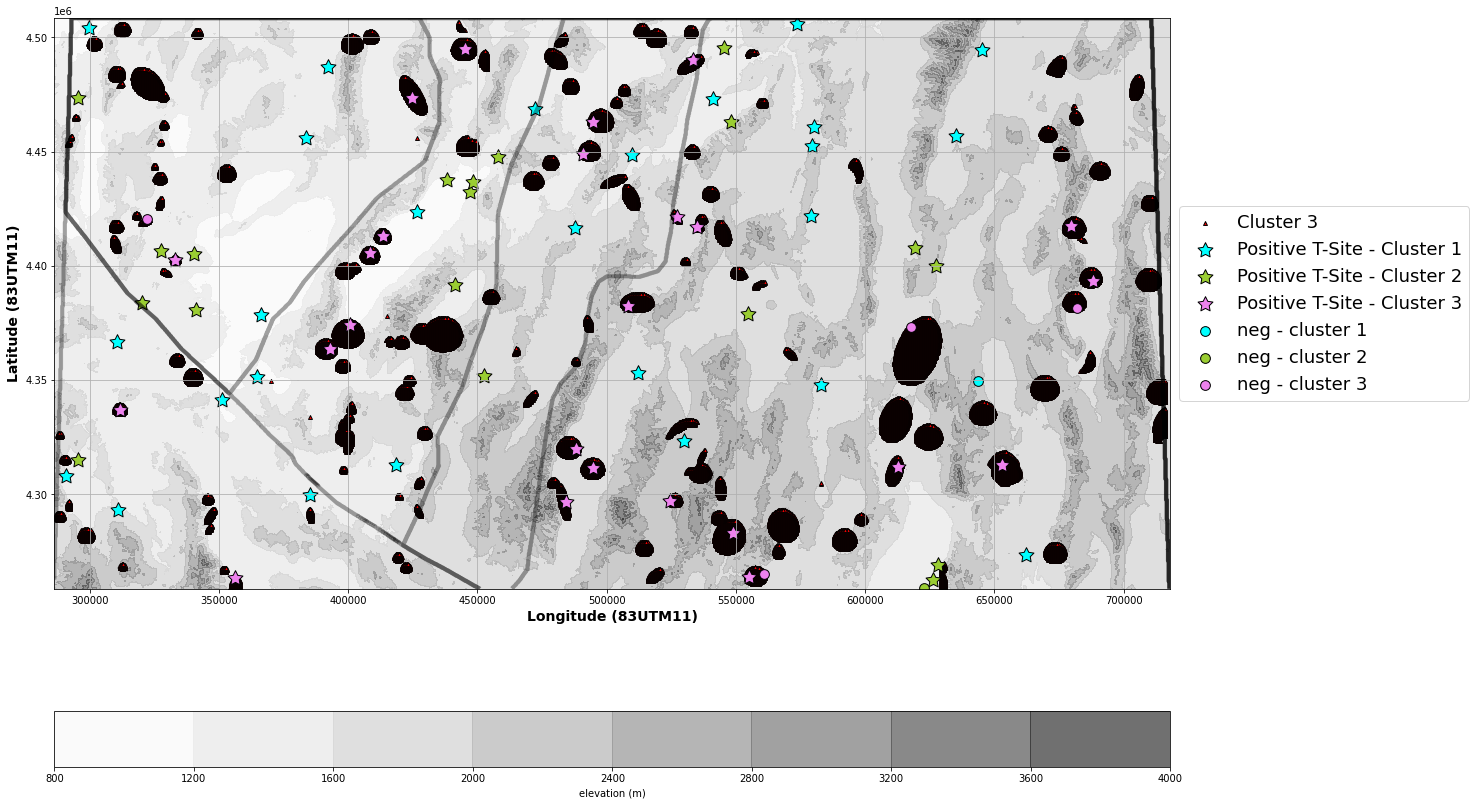

In [ ]:
plt.subplots(figsize=(20,15))

a = df_features['X_83UTM11']
b = df_features['Y_83UTM11']
s = df_features['QuaternaryFaultTraces']

Z = Info.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='Domain').T.values #-9999 in strain messses it up

Za = df_features.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='DEM-30m').T.values #-9999 in strain messses it up

X_unique = np.sort(a.unique())
Y_unique = np.sort(b.unique())
Xa, Ya = np.meshgrid(X_unique, Y_unique)
pd.DataFrame(Z)

#plt.subplot(2,2,1)
plt.rcParams["figure.figsize"] = (20,10)

alpha = 0.7

plt.contour(Xa,Ya,Z,colors='black', linewidths=4, alpha=0.2) #cmap = 'terrain'

plt.contourf(Xa,Ya,Za,cmap = 'Greys', alpha=0.6)
plt.colorbar(label = 'elevation (m)',orientation= 'horizontal')

#plt.scatter(group2['X_83UTM11'], group2['Y_83UTM11'], c='cyan',edgecolors='k',s=15,marker='^', label=label2)
#plt.scatter(group5['X_83UTM11'], group5['Y_83UTM11'], c='red',edgecolors='k',s=15,marker='^', label=label5)
plt.scatter(group8['X_83UTM11'], group8['Y_83UTM11'], c='red',edgecolors='k',s=15,marker='^', label=label8)


plt.scatter(group1['X_83UTM11'], group1['Y_83UTM11'], c='cyan',edgecolors='k', marker=(5, 1),s=245, label=label1)
plt.scatter(group4['X_83UTM11'], group4['Y_83UTM11'],  c='yellowgreen',edgecolors='k', marker=(5, 1),s=245, label=label4)
plt.scatter(group7['X_83UTM11'], group7['Y_83UTM11'],  c='violet',edgecolors='k', marker=(5, 1),s=245, label=label7)


plt.scatter(group3['X_83UTM11'], group3['Y_83UTM11'],  c='cyan', marker='o',edgecolors='k',s=95,label=label3)
plt.scatter(group6['X_83UTM11'], group6['Y_83UTM11'],  c='yellowgreen', marker='o',edgecolors='k',s=95,label=label6)
plt.scatter(group9['X_83UTM11'], group9['Y_83UTM11'],  c='violet', marker='o',edgecolors='k',s=95,label=label9)



plt.xlabel('Longitude (83UTM11)',fontsize=14,fontweight='bold')
plt.ylabel('Latitude (83UTM11)',fontsize=14,fontweight='bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize = 18)
plt.grid(True)

#plt.colorbar()
plt.tight_layout

# TsNE Analysis

##Training Site TsNE




### t-sne tsite prep

In [ ]:
 #Make a new dataframe to append cluster results to
X_reset = X.reset_index( drop=True,inplace = False, col_level=0, col_fill='')
df_cluster = pd.DataFrame(X_reset)
#df_cluster.reset_index(inplace = False) #set to True if you want to keep original index
df_cluster

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance
0,-0.077146,0.123386,-0.332096,0.086902,-0.842737,-1.069723,0.955813,1.252825,-0.542880,-2.062464,-0.748703,1.120357,-0.905409,0.974860,0.271446,8.085140,-0.809039,0.307496,-1.625404,-1.789559
1,0.968005,1.977548,0.165562,2.112309,-1.064303,0.039597,-0.754745,-0.986603,-1.008622,0.733905,1.330451,-0.206034,-2.007012,0.167345,0.729581,1.878564,0.872650,1.549683,0.394125,-1.750235
2,1.500437,1.040333,2.782966,0.224482,-0.965216,0.346868,1.213427,1.670390,2.105045,-0.760399,-0.140574,3.080725,0.415872,-0.755529,1.187716,6.065689,0.499869,-1.170396,-1.109560,-0.899726
3,-0.532491,-0.585928,-0.402840,-0.584707,-0.083387,-1.179981,1.161904,1.327701,-0.875585,2.029360,0.116588,0.187495,0.765071,1.090220,-1.561095,-0.185826,0.480697,0.411948,-0.387379,0.288987
4,1.622680,1.970924,3.679474,1.836230,-1.064303,2.045043,-0.291040,1.187514,1.606740,-2.461928,-0.226611,1.067508,1.728364,-1.563044,-0.301223,11.674732,-0.868997,-0.728054,-1.996811,-1.739933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,4.049126,1.601313,0.051252,1.475819,1.603709,0.529496,-0.517740,-0.529951,-1.124389,0.157383,-1.049719,-0.041029,0.212232,-1.101607,0.500513,2.691011,-0.155244,-1.650585,0.125886,-1.794166
141,0.926993,1.490994,3.280054,1.600078,-1.064303,2.445875,0.007793,0.649494,0.185227,-0.518430,-0.133906,0.043048,0.991519,-1.563044,-1.332028,5.794412,-1.128166,-1.659904,-1.166303,-1.556529
142,-0.509868,-0.553570,-0.399280,-0.550632,-0.029800,-0.090246,-0.363172,-1.398668,-0.818826,0.707490,0.778441,-0.871573,0.080408,1.667016,0.042378,-0.185826,-0.634230,-0.895042,-0.575662,0.218124
143,-0.532675,-0.586038,-0.402688,-0.584791,0.486661,-0.293295,-0.692918,-1.867938,0.084414,0.678824,1.313787,-1.074379,-0.594781,0.398064,0.729581,-0.185826,-0.197778,0.195520,-0.317740,0.909682


In [ ]:
time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
X_embedded = tsne.fit_transform(X)
print (X_embedded.shape)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

NameError: ignored

In [ ]:
Y = pd.DataFrame(y)
Y_reset = Y.reset_index( drop=True,inplace = False, col_level=0, col_fill='')

df_cluster['y'] = pd.concat([Y_reset],axis=1,sort=False)

df_cluster['tsneX'] = X_embedded[:,0]
df_cluster['tsneY'] = X_embedded[:,1]

df_cluster.head()

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

points = ax.scatter(df_cluster['tsneX'], df_cluster['tsneY'], edgecolors='k', 
                    marker='o', c=df_cluster['y'],
#                     marker='o', c='k',
                   s=200, cmap="coolwarm", alpha=0.5)

# for a,b,c in zip(df_subset.tsneX, df_subset.tsneY, XyInfo.id_rc): 
#     ax.annotate(c, (a-0.2,b-0.1), fontsize=5, color='k')

ax.axis('square')
ax.grid(True)

cb = fig.colorbar(points)
cb.set_label('probability of (+)',fontsize=16)

plt.title('2D t-SNE clusters',fontsize=18);

# plt.savefig('t-SNE.png')

In [ ]:
## need to implement t-SNE reprocucibility here
### 1. take a baseline case, say numerical structural features with their actual values
### 2. do initial t-SNE cluster
### 3. do a simple lineary ANN regression on features -> tsneX, tsneY
### 4. use this model to remap further cases to equivalent t-SNE reduced coordinates

### T-SNE tsite KMeans analysis

In [ ]:
from sklearn.cluster import KMeans
cols = df_cluster.columns


nCluster = 2

Kmean = KMeans(n_clusters=nCluster, init='k-means++',
               verbose=2, algorithm="elkan",
               n_init=10, max_iter=300, tol=0.000001)

Kmean.fit(df_cluster[['tsneX','tsneY']])

In [ ]:
centers = np.copy(Kmean.cluster_centers_)
print('centers.ndim: {}'.format(centers.ndim))
print('centers.shape: {}'.format(centers.shape))
print('centers.size: {}'.format(centers.size))
print(centers)

Labels = Kmean.labels_

df_labels = pd.DataFrame({'KMeansGrp':Labels,
                          'Grp0_CntrX':centers[0,0],
                          'Grp0_CntrY':centers[0,1],
                          'Grp1_CntrX':centers[1,0],
                          'Grp1_CntrY':centers[1,1]})

df_out = pd.concat([df_cluster, df_labels], axis=1, sort=False)

print("Last 5 rows of df_out:", file=sys.stdout, flush=True)
print(df_out.tail(5).to_string(), file=sys.stdout, flush=True)
print('', file=sys.stdout, flush=True)

In [ ]:
group1 = df_out[(df_out['y'] == 1) & (df_out['KMeansGrp'] == 0)]
group2 = df_out[(df_out['y'] != 1) & (df_out['KMeansGrp'] == 0)]
group3 = df_out[(df_out['y'] == 1) & (df_out['KMeansGrp'] == 1)]
group4 = df_out[(df_out['y'] != 1) & (df_out['KMeansGrp'] == 1)]



In [ ]:
"""
# Use tsneX from visual inspection to discriminate
tsneX_sep = 0.7
group1 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['tsneX'] <= tsneX_sep)]
group2 = df_out[(df_out['TrainCodePos'] != 1) & (df_out['tsneX'] <= tsneX_sep)]
group3 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['tsneX'] > tsneX_sep)]
group4 = df_out[(df_out['TrainCodePos'] != 1) & (df_out['tsneX'] > tsneX_sep)]
"""

label1 = 'Positive Train - Cluster 1'
label2 = 'Negative Train - Cluster 1'
label3 = 'Positive Train - Cluster 2'
label4 = 'Negative Train - Cluster 2'

plt.subplots(figsize=(10,7.5))
plt.scatter(group1['tsneX'], group1['tsneY'], c='red', marker='o', label=label1)
plt.scatter(group3['tsneX'], group3['tsneY'], c='red', marker='^', label=label3)
plt.scatter(group4['tsneX'], group4['tsneY'], c='#33a02c', marker='o',label=label4)
plt.scatter(group2['tsneX'], group2['tsneY'], c='#33a02c', marker='^',label=label2)

plt.scatter(centers[0,0], centers[0,1], s=100, c='blue', marker='s',
            label='Cluster 1 Center')
plt.scatter(centers[1,0], centers[1,1], s=100, c='#ffaa00', marker='s',
            label='Cluster 2 Center')
plt.legend()
plt.grid(True)
plt.title('KMeans Analysis with\n2D t-SNE clusters - ' + ' dfN' ' local',fontsize=14);

In [ ]:
XyInfo.reset_index(inplace = True) 
group1_info = pd.concat([group1,XyInfo], axis=1, sort=False).dropna()
group2_info = pd.concat([group2,XyInfo], axis=1, sort=False).dropna()
group3_info = pd.concat([group3,XyInfo], axis=1, sort=False).dropna()
group4_info = pd.concat([group4,XyInfo],axis=1, sort=False).dropna()

In [ ]:
idx_null=df_features.index[df_features['NullInfo']=='nullValue'].to_numpy().tolist()
df_features = df_features.replace(-9999, np.nan)
df_features=df_features.replace(-9999, 0)
print(df_features.shape)

In [ ]:
#Plot the Kmeans results with lat lon

label1 = 'Positive Train - Cluster 1-G1'
label2 = 'Negative Train - Cluster 1-G2'
label3 = 'Positive Train - Cluster 2-G3'
label4 = 'Negative Train - Cluster 2-G4'

#plt.subplots(figsize=(10,7.5))


a = df_features['X_83UTM11']
b = df_features['Y_83UTM11']
s = df_features['QuaternaryFaultTraces']

#df_features['GeodeticStrainRate']

Z = df_features.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='Fairway').T.values #

X_unique = np.sort(a.unique())
Y_unique = np.sort(b.unique())
Xa, Ya = np.meshgrid(X_unique, Y_unique)
pd.DataFrame(Z)

#plt.subplot(2,2,1)
plt.rcParams["figure.figsize"] = (20,10)

alpha = 0.7
plt.contourf(Xa,Ya,Z, alpha=0.35,cmap='rainbow')


plt.scatter(group1_info['X_83UTM11'], group1_info['Y_83UTM11'], c='red', marker='o', s= 75, label=label1)
plt.scatter(group3_info['X_83UTM11'], group3_info['Y_83UTM11'], c='red', marker='^', s= 75,label=label3)
plt.scatter(group4_info['X_83UTM11'], group4_info['Y_83UTM11'], c='#33a02c', marker='o',s= 75,label=label4)
plt.scatter(group2_info['X_83UTM11'], group2_info['Y_83UTM11'], c='#33a02c', marker='^',s= 75, label=label2)
plt.xlabel('Longitude (83UTM11)',fontsize=14,fontweight='bold')
plt.ylabel('Latitude (83UTM11)',fontsize=14,fontweight='bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.title('T-Site distribution\n2D t-SNE/Kmeans clusters - ' + ' Numerical Features',fontsize=14,fontweight='bold');